In [61]:
from sklearn.datasets import make_moons
import torch
import pandas as pd

device = 'cuda' if torch.cuda.is_available() else 'cpu'

RANDOM_SEED = 42

X,y = make_moons(n_samples=1000, noise=0.1, random_state=RANDOM_SEED)

df = pd.DataFrame({'X1':X[:,0], 'X2':X[:,1], 'target':y})

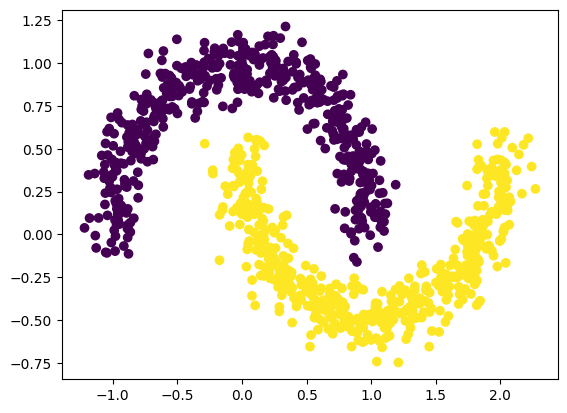

In [62]:
import matplotlib.pyplot as plt

plt.scatter(df.X1, df.X2, c=df.target)
plt.show()

In [63]:
from sklearn.model_selection import train_test_split

X = torch.tensor(X, dtype=torch.float)
y = torch.tensor(y, dtype=torch.float)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=RANDOM_SEED, stratify=y)



In [64]:
from torch import nn

class MoonModule(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(in_features=2, out_features=10),
            nn.ReLU(),
            nn.Linear(in_features=10, out_features=10),
            nn.ReLU(),
            nn.Linear(in_features=10, out_features=1)
        )
        self.model.to(device)

    def forward(self, x):
        return self.model(x)
        
model = MoonModule()
model.state_dict()

OrderedDict([('model.0.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188],
                      [ 0.6146,  0.1323],
                      [ 0.5224,  0.0958],
                      [ 0.3410, -0.0998],
                      [ 0.5451,  0.1045],
                      [-0.3301,  0.1802]], device='cuda:0')),
             ('model.0.bias',
              tensor([-0.3258, -0.0829, -0.2872,  0.4691, -0.5582, -0.3260, -0.1997, -0.4252,
                       0.0667, -0.6984], device='cuda:0')),
             ('model.2.weight',
              tensor([[ 0.2856, -0.2686,  0.2441,  0.0526, -0.1027,  0.1954,  0.0493,  0.2555,
                        0.0346, -0.0997],
                      [ 0.0850, -0.0858,  0.1331,  0.2823,  0.1828, -0.1382,  0.1825,  0.0566,
                        0.1606, -0.1927],
                      [-0.3130, -0.122

In [65]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)

In [66]:
from torchmetrics import Accuracy

acc_dn = Accuracy(task='binary').to(device)

In [67]:
torch.manual_seed(RANDOM_SEED)

epochs = 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):

    model.train()

    y_logits = model(X_train).squeeze()
    y_preds = torch.round(torch.sigmoid(y_logits))

    loss = loss_fn(y_logits, y_train)

    acc = acc_dn(y_preds, y_train.int())

    optimizer.zero_grad()

    loss.backward()
    
    optimizer.step()

    model.eval()
    with torch.inference_mode():
        test_logits = model(X_test).squeeze()
        test_preds = torch.round(torch.sigmoid(test_logits))
        testloss = loss_fn(test_logits, y_test)
        acctest = acc_dn(test_preds, y_test)

    if (epoch+1) % 100 == 0:
        print(f"Epoch: {epoch+1}, Loss: {loss:.4f}, Accuracy: {acc*100:.2f}%, Loss Test: {testloss:.4f}, Test Accuracy: {acctest*100:.2f}%")

Epoch: 100, Loss: 0.4118, Accuracy: 78.88%, Loss Test: 0.3791, Test Accuracy: 85.50%
Epoch: 200, Loss: 0.2589, Accuracy: 87.75%, Loss Test: 0.2077, Test Accuracy: 91.00%
Epoch: 300, Loss: 0.2168, Accuracy: 90.38%, Loss Test: 0.1642, Test Accuracy: 94.50%
Epoch: 400, Loss: 0.1787, Accuracy: 92.25%, Loss Test: 0.1350, Test Accuracy: 95.50%
Epoch: 500, Loss: 0.1322, Accuracy: 95.12%, Loss Test: 0.1012, Test Accuracy: 96.50%
Epoch: 600, Loss: 0.0919, Accuracy: 97.62%, Loss Test: 0.0717, Test Accuracy: 97.00%
Epoch: 700, Loss: 0.0644, Accuracy: 98.75%, Loss Test: 0.0513, Test Accuracy: 99.50%
Epoch: 800, Loss: 0.0477, Accuracy: 99.00%, Loss Test: 0.0384, Test Accuracy: 99.50%
Epoch: 900, Loss: 0.0373, Accuracy: 99.12%, Loss Test: 0.0303, Test Accuracy: 99.50%
Epoch: 1000, Loss: 0.0305, Accuracy: 99.38%, Loss Test: 0.0250, Test Accuracy: 99.50%


In [68]:
# Plot the model predictions

import numpy as np

# TK - this could go in the helper_functions.py and be explained there
def plot_decision_boundary(model, X, y):
  
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Source - https://madewithml.com/courses/foundations/neural-networks/ 
    # (with modifications)
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), 
                         np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # mutli-class
    else: 
        y_pred = torch.round(torch.sigmoid(y_logits)) # binary
    
    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

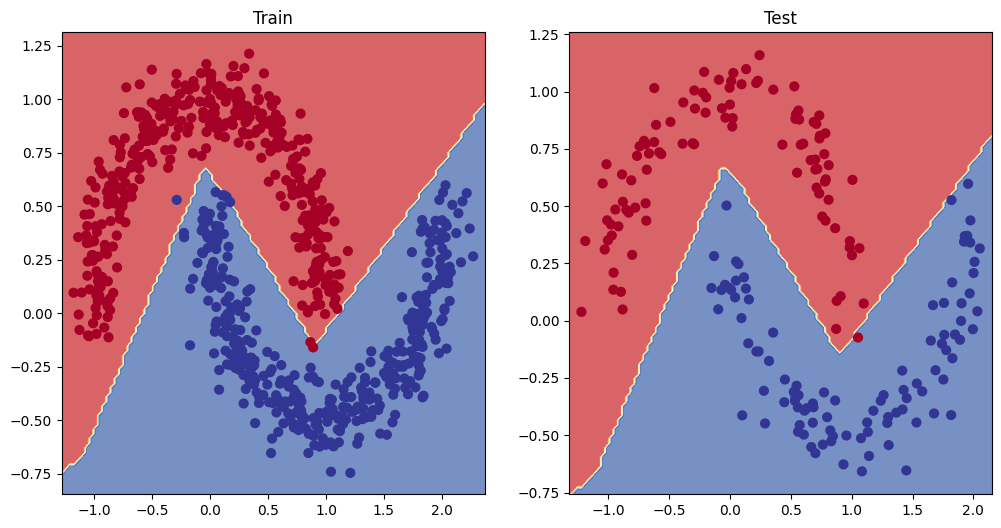

In [69]:

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, X_test, y_test)